In [2]:
import torch
from pytorch_transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm_notebook
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.core.display import display, HTML
import math

np.random.seed(1)
torch.manual_seed(1)

In [3]:
from experiment import Intervention, Model

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = Model()

## Run experiment

#### Set parameters of initial experiment

In [5]:
base_sentence = "The {} said that"
biased_word = "teacher"
intervention = Intervention(
    tokenizer,
    base_sentence,
    [biased_word, "man", "woman"],
    ["he", "she"])

#### Run intervention
Erase each attention head in turn and measure change in candidate probabilities

In [ ]:
 """ Code draws on https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py """
with torch.no_grad():
    '''
    Now intervening on potentially biased example
    '''
    context = intervention.base_strings_tok[0]
    '''
    Probabilities without intervention (Base case)
    '''
    base_probs = model.get_probabilities_for_examples(
        context,
        intervention.candidates_tok)
    print("Base case: {} ____".format(intervention.base_strings[0]))
    for token, prob in zip(intervention.candidates, base_probs):
        print("{}: {:.2f}%".format(token, prob * 100))

    '''
    Intervene at every possible layer / head
    '''
    candidate1_probs = torch.zeros((model.num_layers, model.num_heads))
    candidate2_probs = torch.zeros((model.num_layers, model.num_heads))

#     model.num_layers = 2
#     model.num_heads = 2
    for layer in tqdm_notebook(range(model.num_layers), desc='layers'):
        for head in tqdm_notebook(range(model.num_heads), desc='heads'):
            candidate1_prob, candidate2_prob = model.head_pruning_intervention(
                context=context,
                outputs=intervention.candidates_tok,
                layer=layer,
                head=head)
            candidate1_probs[layer, head] = candidate1_prob * 100
            candidate2_probs[layer, head] = candidate2_prob * 100

#### Report results
In each heatmap, rows correspond to layers and columns to heads. Each cell contains the odds ratio for the intervention of erasing the corresponding layer/head.

Odds ratio: (p("HE"|intervention) / p("SHE"|intervention)) / (p("HE") / p("SHE"))


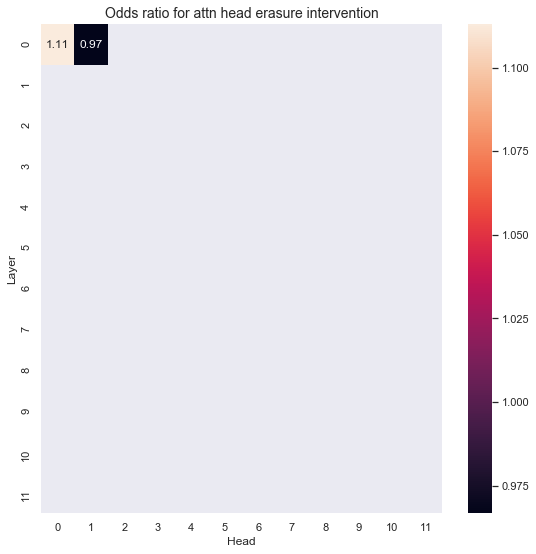

In [7]:
candidate1 = intervention.candidates[0][1:].upper()
candidate2 = intervention.candidates[1][1:].upper()
candidate1_base_prob = base_probs[0]
candidate2_base_prob = base_probs[1]

odds_base = candidate1_base_prob / candidate2_base_prob
odds_intervention = candidate1_probs / candidate2_probs
odds_ratio = odds_intervention / odds_base

print(f'Odds ratio: (p("{candidate1}"|intervention) / p("{candidate2}"|intervention)) / (p("{candidate1}") / p("{candidate2}"))')

visualize = True
if visualize:
    plt.figure(figsize=(9,9)) 
    ax = sns.heatmap(odds_ratio, annot=True, annot_kws={"size": 12}, fmt=".2f")
    ax.set_title("Odds ratio for attn head erasure intervention", size=14)
    ax.set(xlabel='Head', ylabel='Layer')
else:
    torch.set_printoptions(precision=1, sci_mode=False)
    print(arr)